In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE
# from src.backup import CrossSpeciesVAE
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gene_embeddings, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}
homology_edges, homology_scores = pickle.load(open('species_homology_info.pkl','rb'))

batch_size = 256
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=1.0,
)

early_stopping = EarlyStopping(
    monitor='val_recon',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=300,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_recon",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | mu_layer        | Linear        | 16.5 K | train
1 | logvar_layer    | Linear        | 16.5 K | train
2 | encoders        | ModuleDict    | 27.0 M | train
3 | decoders        | ModuleDict    | 53.9 M | tr

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 12/12 [00:03<00:00,  3.69it/s, v_num=201]   

Metric val_recon improved. New best score: 6.854


Epoch 1: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, v_num=201]   

Metric val_recon improved by 0.716 >= min_delta = 0.0. New best score: 6.137


Epoch 3: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s, v_num=201]   

Metric val_recon improved by 0.202 >= min_delta = 0.0. New best score: 5.935


Epoch 5: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s, v_num=201]   

Metric val_recon improved by 0.271 >= min_delta = 0.0. New best score: 5.664


Epoch 7: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s, v_num=201]   

Metric val_recon improved by 0.028 >= min_delta = 0.0. New best score: 5.636


Epoch 8: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, v_num=201]   

Metric val_recon improved by 0.179 >= min_delta = 0.0. New best score: 5.457


Epoch 9: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s, v_num=201]   

Metric val_recon improved by 0.004 >= min_delta = 0.0. New best score: 5.453


Epoch 10: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, v_num=201]  

Metric val_recon improved by 0.176 >= min_delta = 0.0. New best score: 5.277


Epoch 11: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.028 >= min_delta = 0.0. New best score: 5.248


Epoch 12: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, v_num=201]  

Metric val_recon improved by 0.111 >= min_delta = 0.0. New best score: 5.138


Epoch 13: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, v_num=201]  

Metric val_recon improved by 0.177 >= min_delta = 0.0. New best score: 4.961


Epoch 15: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s, v_num=201]  

Metric val_recon improved by 0.039 >= min_delta = 0.0. New best score: 4.922


Epoch 16: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s, v_num=201]  

Metric val_recon improved by 0.095 >= min_delta = 0.0. New best score: 4.827


Epoch 17: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s, v_num=201]  

Metric val_recon improved by 0.044 >= min_delta = 0.0. New best score: 4.783


Epoch 18: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, v_num=201]  

Metric val_recon improved by 0.127 >= min_delta = 0.0. New best score: 4.655


Epoch 19: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s, v_num=201]  

Metric val_recon improved by 0.004 >= min_delta = 0.0. New best score: 4.652


Epoch 20: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201]  

Metric val_recon improved by 0.150 >= min_delta = 0.0. New best score: 4.502


Epoch 21: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201]  

Metric val_recon improved by 0.139 >= min_delta = 0.0. New best score: 4.363


Epoch 23: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201]  

Metric val_recon improved by 0.003 >= min_delta = 0.0. New best score: 4.361


Epoch 24: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s, v_num=201]  

Metric val_recon improved by 0.086 >= min_delta = 0.0. New best score: 4.275


Epoch 25: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.006 >= min_delta = 0.0. New best score: 4.269


Epoch 26: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s, v_num=201]  

Metric val_recon improved by 0.129 >= min_delta = 0.0. New best score: 4.140


Epoch 27: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=201]  

Metric val_recon improved by 0.024 >= min_delta = 0.0. New best score: 4.117


Epoch 28: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s, v_num=201]  

Metric val_recon improved by 0.124 >= min_delta = 0.0. New best score: 3.993


Epoch 29: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s, v_num=201]  

Metric val_recon improved by 0.110 >= min_delta = 0.0. New best score: 3.882


Epoch 31: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s, v_num=201]  

Metric val_recon improved by 0.102 >= min_delta = 0.0. New best score: 3.781


Epoch 33: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s, v_num=201]  

Metric val_recon improved by 0.095 >= min_delta = 0.0. New best score: 3.686


Epoch 35: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201]  

Metric val_recon improved by 0.014 >= min_delta = 0.0. New best score: 3.672


Epoch 36: 100%|██████████| 12/12 [00:02<00:00,  4.57it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s, v_num=201]  

Metric val_recon improved by 0.090 >= min_delta = 0.0. New best score: 3.582


Epoch 37: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.006 >= min_delta = 0.0. New best score: 3.576


Epoch 38: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s, v_num=201]  

Metric val_recon improved by 0.046 >= min_delta = 0.0. New best score: 3.531


Epoch 39: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=201]  

Metric val_recon improved by 0.006 >= min_delta = 0.0. New best score: 3.525


Epoch 40: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201]  

Metric val_recon improved by 0.052 >= min_delta = 0.0. New best score: 3.473


Epoch 41: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s, v_num=201]  

Metric val_recon improved by 0.057 >= min_delta = 0.0. New best score: 3.416


Epoch 43: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s, v_num=201]  

Metric val_recon improved by 0.067 >= min_delta = 0.0. New best score: 3.349


Epoch 45: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201]  

Metric val_recon improved by 0.022 >= min_delta = 0.0. New best score: 3.327


Epoch 46: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s, v_num=201]  

Metric val_recon improved by 0.036 >= min_delta = 0.0. New best score: 3.292


Epoch 47: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s, v_num=201]  

Metric val_recon improved by 0.054 >= min_delta = 0.0. New best score: 3.237


Epoch 49: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s, v_num=201]  

Metric val_recon improved by 0.059 >= min_delta = 0.0. New best score: 3.178


Epoch 51: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s, v_num=201]  

Metric val_recon improved by 0.057 >= min_delta = 0.0. New best score: 3.121


Epoch 53: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=201]  

Metric val_recon improved by 0.009 >= min_delta = 0.0. New best score: 3.113


Epoch 54: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201]  

Metric val_recon improved by 0.029 >= min_delta = 0.0. New best score: 3.084


Epoch 55: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s, v_num=201]  

Metric val_recon improved by 0.050 >= min_delta = 0.0. New best score: 3.034


Epoch 57: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s, v_num=201]  

Metric val_recon improved by 0.038 >= min_delta = 0.0. New best score: 2.996


Epoch 59: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, v_num=201]  

Metric val_recon improved by 0.020 >= min_delta = 0.0. New best score: 2.976


Epoch 61: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, v_num=201]  

Metric val_recon improved by 0.036 >= min_delta = 0.0. New best score: 2.940


Epoch 63: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s, v_num=201]  

Metric val_recon improved by 0.042 >= min_delta = 0.0. New best score: 2.899


Epoch 65: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s, v_num=201]  

Metric val_recon improved by 0.015 >= min_delta = 0.0. New best score: 2.884


Epoch 66: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s, v_num=201]  

Metric val_recon improved by 0.034 >= min_delta = 0.0. New best score: 2.850


Epoch 69: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.024 >= min_delta = 0.0. New best score: 2.826


Epoch 70: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s, v_num=201]  

Metric val_recon improved by 0.022 >= min_delta = 0.0. New best score: 2.804


Epoch 73: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 73: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.008 >= min_delta = 0.0. New best score: 2.796


Epoch 74: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, v_num=201]  

Metric val_recon improved by 0.023 >= min_delta = 0.0. New best score: 2.773


Epoch 75: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s, v_num=201]  

Metric val_recon improved by 0.031 >= min_delta = 0.0. New best score: 2.743


Epoch 77: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]  

Metric val_recon improved by 0.024 >= min_delta = 0.0. New best score: 2.719


Epoch 78: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s, v_num=201]  

Metric val_recon improved by 0.021 >= min_delta = 0.0. New best score: 2.698


Epoch 83: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, v_num=201]  

Metric val_recon improved by 0.019 >= min_delta = 0.0. New best score: 2.678


Epoch 85: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, v_num=201]  

Metric val_recon improved by 0.026 >= min_delta = 0.0. New best score: 2.653


Epoch 87: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, v_num=201]  

Metric val_recon improved by 0.012 >= min_delta = 0.0. New best score: 2.641


Epoch 89: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s, v_num=201]  

Metric val_recon improved by 0.002 >= min_delta = 0.0. New best score: 2.639


Epoch 90: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201]  

Metric val_recon improved by 0.020 >= min_delta = 0.0. New best score: 2.619


Epoch 91: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 91: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201]  

Metric val_recon improved by 0.009 >= min_delta = 0.0. New best score: 2.610


Epoch 92: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201]  

Metric val_recon improved by 0.006 >= min_delta = 0.0. New best score: 2.604


Epoch 94: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 94: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, v_num=201]  

Metric val_recon improved by 0.031 >= min_delta = 0.0. New best score: 2.573


Epoch 95: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 96: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 97: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, v_num=201]  

Metric val_recon improved by 0.005 >= min_delta = 0.0. New best score: 2.567


Epoch 99: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|██████████| 12/12 [00:02<00:00,  4.31it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s, v_num=201] 

Metric val_recon improved by 0.025 >= min_delta = 0.0. New best score: 2.543


Epoch 102: 100%|██████████| 12/12 [00:02<00:00,  4.29it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, v_num=201] 

Metric val_recon improved by 0.001 >= min_delta = 0.0. New best score: 2.541


Epoch 103: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s, v_num=201] 

Metric val_recon improved by 0.024 >= min_delta = 0.0. New best score: 2.517


Epoch 104: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 105: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 106: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 106: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s, v_num=201] 

Metric val_recon improved by 0.003 >= min_delta = 0.0. New best score: 2.514


Epoch 107: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201] 

Metric val_recon improved by 0.001 >= min_delta = 0.0. New best score: 2.513


Epoch 108: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 109: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 110: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 110: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s, v_num=201] 

Metric val_recon improved by 0.019 >= min_delta = 0.0. New best score: 2.495


Epoch 111: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201] 

Metric val_recon improved by 0.017 >= min_delta = 0.0. New best score: 2.478


Epoch 112: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s, v_num=201] 

Metric val_recon improved by 0.002 >= min_delta = 0.0. New best score: 2.476


Epoch 114: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|██████████| 12/12 [00:02<00:00,  4.08it/s, v_num=201] 

Metric val_recon improved by 0.023 >= min_delta = 0.0. New best score: 2.453


Epoch 115: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 116: 100%|██████████| 12/12 [00:02<00:00,  4.35it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 118: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s, v_num=201]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 119:  25%|██▌       | 3/12 [00:01<00:03,  2.65it/s, v_num=201]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

<!-- I got rid of fusion, but noticed that the signal in homology weights got much weaker. It makes sense I think, no?
The learning signal is A-->Encoder-->A vs A-->Linear Transform --> Encoder --> A
Alternatively, it is A-->Encoder-->A vs A-->Linear Transform --> Encoder --> B (B vs Linear Transform) -->

// Doing this next. I think I'm going to switch gears and implement the multi-species batches, though, and fix the homology loss.
 
// I can also try adding fusion by default, but still using decoder_A for species_A

Also, sigmoid compresses really strong. i think it needs to be centered around 0.5 so sigmoid(0) == 0

!!!!!!!PRIORITY!!!!!!
there's a bug. after i did some refactoring, the embeddings are degenerating. or it's because of the fusion.

i think i need to check what outcome looks like when i just do direct reconstruction with no homology stuff. if still degenerating, then it's a product of the fusion/conditioning.

without homology loss, but using the cross species reconstruction, it is still degenerating. trying now with only direct reconstruction. it's likely the fusion.

DIRECT RECONSTRUCTION ALONE DOES NOT DEGENERATE.


ok, so, homology loss was also weird. previously, we didn't do fusion for homology loss. we probably shouldn't even do fusion for it.

Best model path: /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints/crossspecies_vae-epoch=114.ckpt


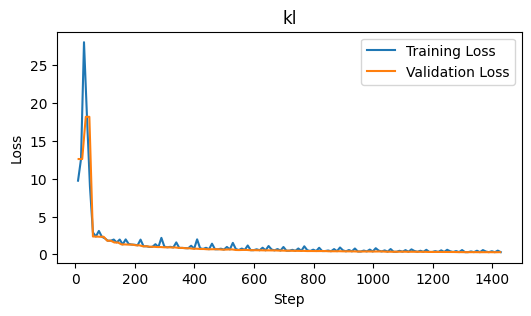

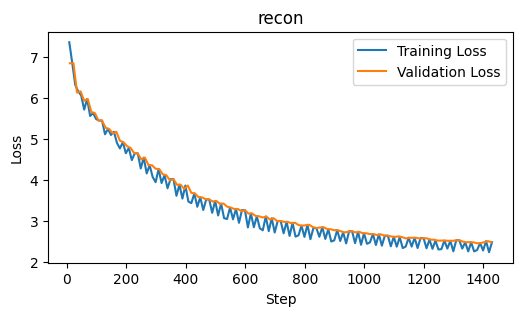

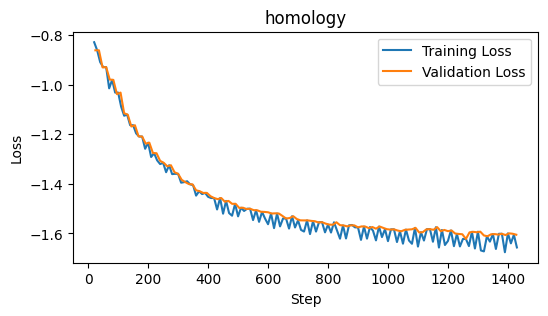

In [4]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["kl", "recon", "homology"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

0.5319059572289244
0.42909534080596184
0.6171161321133338


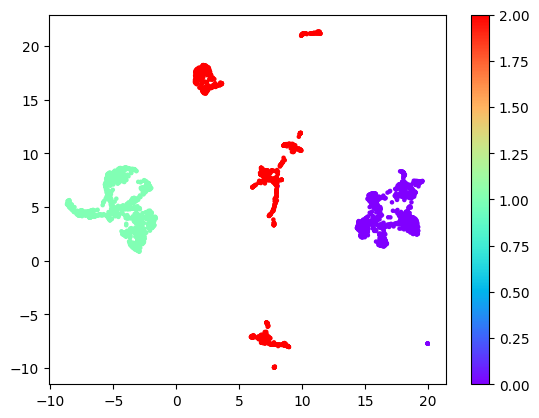

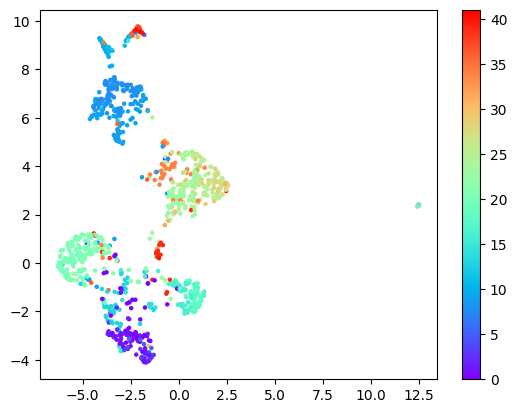

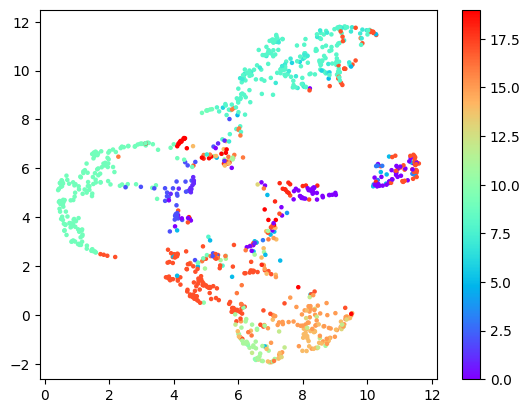

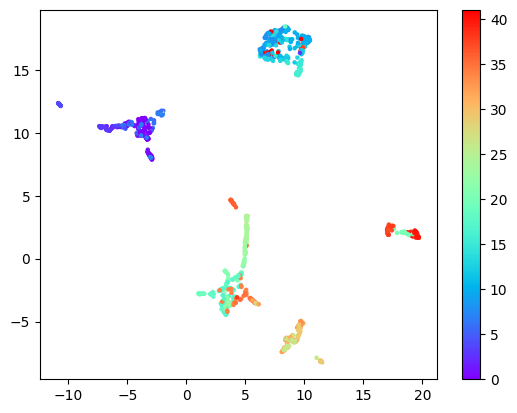

In [5]:

output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

0.5457992849445081
0.40048333671547787
0.5709017220110051


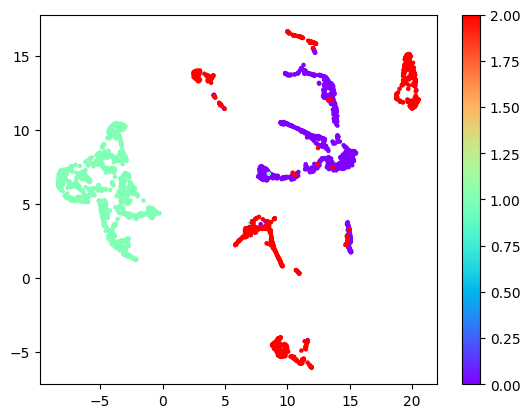

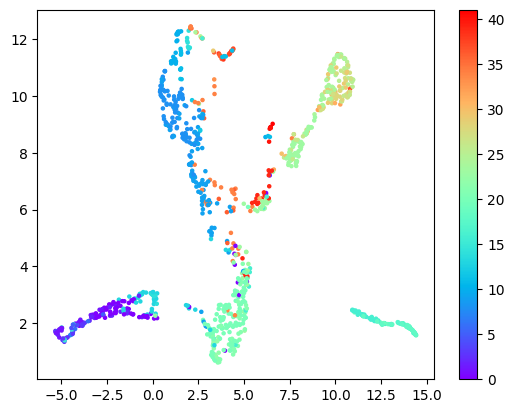

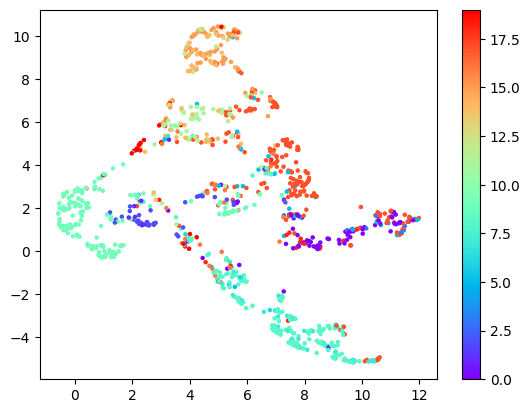

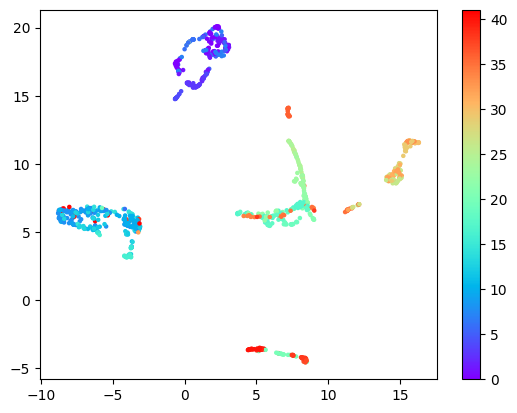

In [5]:

output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [6]:
from scipy.stats import spearmanr

for i, adata in enumerate([adata1, adata2, adata3]):
    x = model.encoders[str(i)].gene_importance(torch.tensor(adata.X.toarray()).to('cuda')).detach().cpu().numpy()
    mu = x.mean(0)
    mu[mu==0]=1
    a = x.var(0)/mu
    b = adata.var['weights'].values

    # plt.figure(); plt.scatter(a,b,s=1);
    # plt.figure(); plt.scatter(x.var(0),adata.X.toarray().var(0),s=1);    
    print(i)
    print('pearson',np.corrcoef(a,b)[0,1])
    print('spearman',spearmanr(a,b).statistic)


0
pearson 0.2832592560446882
spearman 0.2979231431460105
1
pearson 0.19587512479229294
spearman 0.13099577450453478
2
pearson 0.539236023300385
spearman 0.8300971246394523


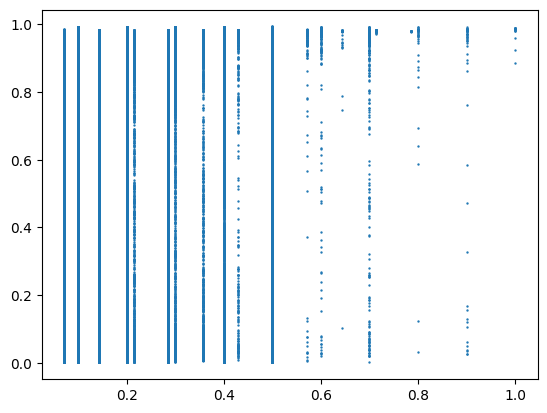

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(sigmoid(model.homology_scores[str(i)][str(j)].detach().cpu().numpy())))
        y.extend(list(sigmoid(model.homology_scores[str(j)][str(i)].detach().cpu().numpy())))
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=0.5);

In [7]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')

In [10]:
import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

2024-12-02 05:29:33,194 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-02 05:29:33,554 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-02 05:29:33,568 - harmonypy - INFO - Iteration 1 of 10
2024-12-02 05:29:33,866 - harmonypy - INFO - Iteration 2 of 10
2024-12-02 05:29:34,153 - harmonypy - INFO - Iteration 3 of 10
2024-12-02 05:29:34,442 - harmonypy - INFO - Iteration 4 of 10
2024-12-02 05:29:34,728 - harmonypy - INFO - Iteration 5 of 10
2024-12-02 05:29:35,013 - harmonypy - INFO - Iteration 6 of 10
2024-12-02 05:29:35,299 - harmonypy - INFO - Iteration 7 of 10
2024-12-02 05:29:35,593 - harmonypy - INFO - Iteration 8 of 10
2024-12-02 05:29:35,866 - harmonypy - INFO - Iteration 9 of 10
2024-12-02 05:29:36,162 - harmonypy - INFO - Iteration 10 of 10
2024-12-02 05:29:36,462 - harmonypy - INFO - Stopped before convergence


In [13]:
adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

In [14]:
adata.write_h5ad('test.h5ad')

In [10]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [11]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [19]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))

A = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
B = c2[indices]

In [26]:
a,c = np.unique(A + '--' + B,return_counts=True)
a[np.argsort(-c)]

array(['Neural--Neural', 'Neoblast--Cathepsin',
       'Epidermal--Tegument_prog', 'Epidermal--Cathepsin',
       'Epidermal--Neoblast', 'Cathepsin+ cells--Cathepsin',
       'Neoblast--Intestine', 'Neural--Parenchymal',
       'Cathepsin+ cells--Neural_KK7', 'Cathepsin+ cells--Neural',
       'Intestine--Cathepsin', 'Muscle--Parenchymal', 'Neural--Neoblast',
       'Muscle--Neural_KK7', 'Cathepsin+ cells--Parenchymal',
       'Neoblast--Muscle', 'Muscle--Neoblast', 'Neural--Muscle',
       'Pharynx--Neural', 'Muscle--Intestine', 'Neural--Flame cells',
       'Cathepsin+ cells--Intestine', 'Parapharyngeal--Muscle',
       'Intestine--Intestine', 'Neoblast--Neoblast', 'Neural--Cathepsin',
       'Protonephridia--Neural', 'Parapharyngeal--Neoblast',
       'Epidermal--Tegument', 'Muscle--Neural', 'Epidermal--Muscle',
       'Epidermal--Neural', 'Protonephridia--Cathepsin', 'Muscle--Gland',
       'Epidermal--Intestine', 'Intestine--Muscle',
       'Intestine--Tegument_prog', 'Neural--Int

In [23]:
pd.DataFrame(B[:20])

,0,1,2,3,4
0,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
1,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
2,Muscle,Intestine,Cathepsin,Cathepsin,Cathepsin
3,Cathepsin,Neoblast,Tegument_prog,Neoblast,Tegument_prog
4,Muscle,Cathepsin,Intestine,Cathepsin,Intestine
5,Muscle,Intestine,Muscle,Neural,Cathepsin
6,Cathepsin,Intestine,Cathepsin,Cathepsin,Parenchymal
7,Muscle,Neoblast,Parenchymal,Cathepsin,Neural
8,Cathepsin,Cathepsin,Intestine,Cathepsin,Cathepsin
9,Neural_KK7,Cathepsin,Gland,Neural_KK7,Parenchymal


In [15]:
B.shape

(1049, 5)

In [41]:
A1 = A[:1049].copy()
A1[i1 < 1049] = "nan"

B1 = B[:1049].copy()
B1[i1 < 1049] = "nan"

B1[:,0] = B[:1049,0]

In [46]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [43]:
pd.DataFrame(B1[(B1[:,1:]=='nan').sum(1) < 4])

,0,1,2,3,4
0,Neural: 1,nan,nan,nan,Neural: 23
1,Pharynx: 25,nan,nan,nan,Parapharyngeal: 12
2,Parapharyngeal: 12,nan,Parapharyngeal: 12,Parapharyngeal: 12,Neoblast: 0
3,Neural: 1,nan,Parapharyngeal: 12,i_smgc1,nan
4,Protonephridia: 26,Neoblast: 0,Neoblast: 0,Neoblast: 0,nan
5,Neural: 9,nan,nan,nan,Neural: 20
6,Neural: 9,nan,nan,nan,Neural: 23
7,Neoblast: 5,Muscle: 14,Muscle: 14,Muscle: 14,Muscle: 14
8,Parapharyngeal: 12,nan,nan,Parapharyngeal: 12,Muscle: 14
9,Neural: 36,nan,nan,enEp_head,nan


In [ ]:
A1

In [34]:
B1

array([['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Neoblast', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['Epidermal', 'Neural', 'Neural', 'Parenchymal', 'Neural'],
       ['Neural', 'nan', 'nan', 'nan', 'nan'],
       ['Neural', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [28]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [27]:
A1

array([['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne